<a href="https://colab.research.google.com/github/Guo0911/generative_ai/blob/main/%5BGenerative_AI%5D_Homework_07b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

使用課程提供的範例資料[政大學術性社團列表](https://raw.githubusercontent.com/yenlung/AI-Demo/refs/heads/master/data/nccu_academic_clubs_complete.txt)

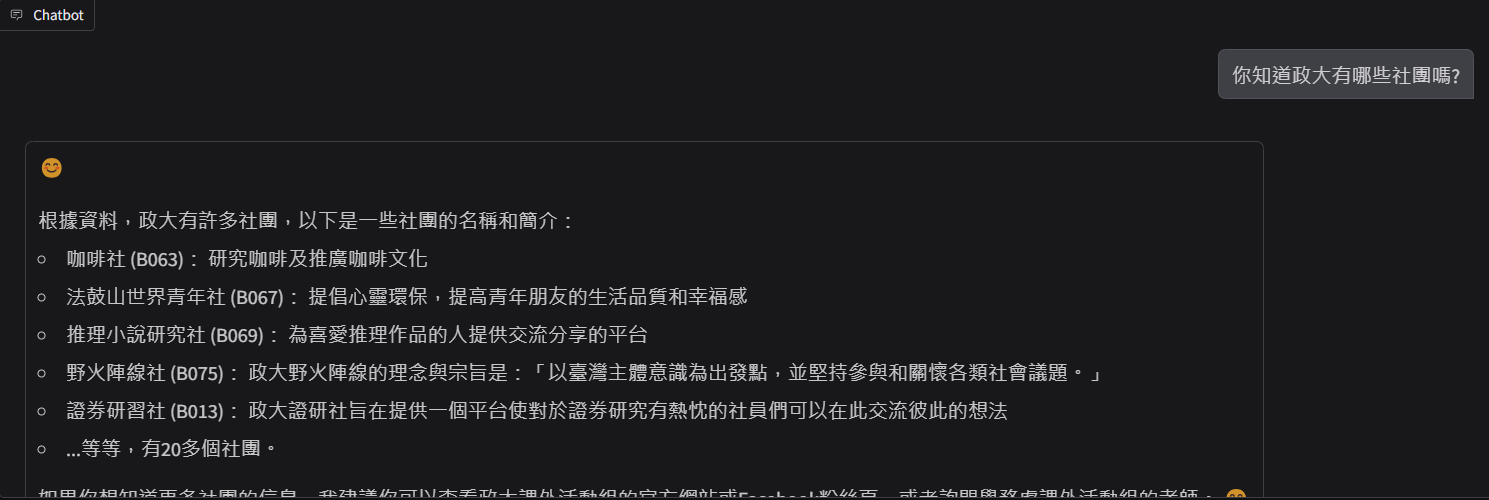

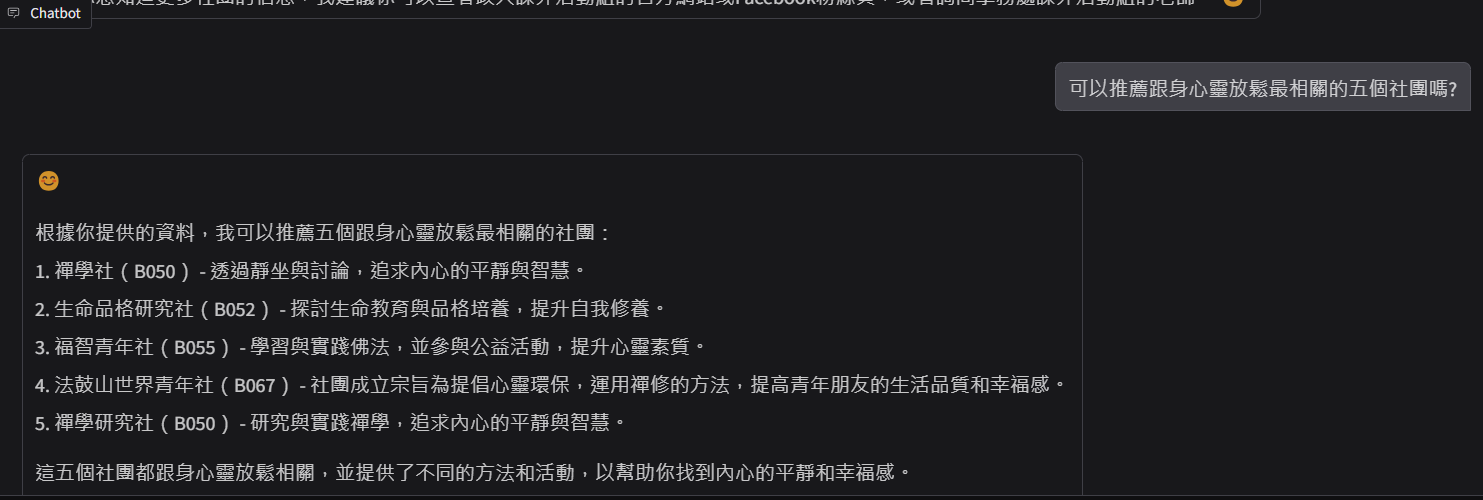

In [1]:
!wget -O faiss_db.zip "https://drive.google.com/uc?export=download&id=1hVqltM_YEXLOr4mVYriJmSvjyGzhudzM"

--2025-04-29 09:15:25--  https://drive.google.com/uc?export=download&id=1hVqltM_YEXLOr4mVYriJmSvjyGzhudzM
Resolving drive.google.com (drive.google.com)... 142.250.107.100, 142.250.107.113, 142.250.107.101, ...
Connecting to drive.google.com (drive.google.com)|142.250.107.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1hVqltM_YEXLOr4mVYriJmSvjyGzhudzM&export=download [following]
--2025-04-29 09:15:25--  https://drive.usercontent.google.com/download?id=1hVqltM_YEXLOr4mVYriJmSvjyGzhudzM&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.142.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41865 (41K) [application/octet-stream]
Saving to: ‘faiss_db.zip’

faiss_db.zip        100%[===================>]  40.88K  --.-KB/s 

In [2]:
!unzip faiss_db.zip

Archive:  faiss_db.zip
   creating: faiss_db/
  inflating: faiss_db/index.pkl      
  inflating: faiss_db/index.faiss    


### 1. 安裝並引入必要套件

In [3]:
!pip install -U langchain langchain-community sentence-transformers faiss-cpu gradio openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.7/322.7 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/88

In [4]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain

In [5]:
from openai import OpenAI
import gradio as gr

### 2. 自訂 E5 embedding 類別

In [6]:
class CustomE5Embedding(HuggingFaceEmbeddings):
    def embed_documents(self, texts):
        texts = [f"passage: {t}" for t in texts]
        return super().embed_documents(texts)

    def embed_query(self, text):
        return super().embed_query(f"query: {text}")

### 3. 載入 `faiss_db`

In [7]:
embedding_model = CustomE5Embedding(model_name="intfloat/multilingual-e5-small")
db = FAISS.load_local("faiss_db", embedding_model, allow_dangerous_deserialization=True)
retriever = db.as_retriever()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/498k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

### 4. 設定好我們要的 LLM

In [8]:
import os
from google.colab import userdata

如之前, 我們會用 OpenAI API。這裡使用 Groq 服務, 可改成你要的服務。

In [10]:
api_key = userdata.get('Groq')

In [11]:
os.environ["OPENAI_API_KEY"] = api_key

這裡的模型和 `base_url` 是用 Groq, 如果用其他服務請自行修改。

In [12]:
model = "llama3-70b-8192"
base_url="https://api.groq.com/openai/v1"

In [13]:
client = OpenAI(
    base_url=base_url # 使用 OpenAI 本身不需要這段
)

### 5. `prompt` 設計

In [14]:
system_prompt = "你是政大的 AI 自主學習輔導員，請根據資料來回應學生的問題。請親切、簡潔並附帶具體建議。請用台灣習慣的中文回應。"

prompt_template = """
根據下列資料回答問題：
{retrieved_chunks}

使用者的問題是：{question}

請根據資料內容回覆，若資料不足請告訴同學可以請教學務處課外活動組的老師。
"""

### 6. 使用 RAG 來回應

搜尋與使用者問題相關的資訊，根據我們的 prompt 樣版去讓 LLM 回應。

In [15]:
chat_history = []

def chat_with_rag(user_input):
    global chat_history
    # 取回相關資料
    docs = retriever.get_relevant_documents(user_input)
    retrieved_chunks = "\n\n".join([doc.page_content for doc in docs])

    # 將自定 prompt 套入格式
    final_prompt = prompt_template.format(retrieved_chunks=retrieved_chunks, question=user_input)

    # 呼叫 OpenAI API
    response = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": final_prompt},
    ]
    )
    answer = response.choices[0].message.content

    chat_history.append((user_input, answer))
    return answer

### 7. 用 Gradio 打造 Web App

In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("# 🎓 AI 自主學習諮詢師")
    chatbot = gr.Chatbot()
    msg = gr.Textbox(placeholder="請輸入你的問題...")

    def respond(message, chat_history_local):
        response = chat_with_rag(message)
        chat_history_local.append((message, response))
        return "", chat_history_local

    msg.submit(respond, [msg, chatbot], [msg, chatbot])

demo.launch(debug=True)

<ipython-input-16-a12785d21538>:3: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b1abf5c816b6d3f7e3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


<ipython-input-15-ef9176c6ed60>:6: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(user_input)
